
# Flower Classification using CNN


### 1. Introduction

There are millions of beautiful flowers bursting around every corner, & we've been constantly awed by the beauty & uniqueness of each flower. Classifiying different flowers from one another is indeed a challenging task, as there're a plethora of flowers to classify & flowers can appear similar to each other. However, classifiying different flowers species will be advantageous in the fields such as the pharmaceutical industry, botany, agricultural, & trade activities, which is why we thought of performing this task.



In [3]:
# Used for manipulating directory paths
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path

# Data visualisation 
import pandas as pd 
import seaborn as sns

# Image manipulation
from PIL import Image
from skimage.io import imread
import cv2

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np 

# Plotting library
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# dl libraries specifically for CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

# training set
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Tells matplotlib to embed plots within the notebook
%matplotlib inline

import math

#### 3.2 Reading the Dataset
After importing the libraries, we began importing the flower data, using the os & pandas modules. We also, extracted & plotted few sample of different flowers for some visualisation.

In [6]:
import pandas as pd
import os
from pathlib import Path

# Path to the folder containing the images
imagesPath = Path("C:\\Users\\User\\Downloads\\4-mds\\4-mds")

# Path to the CSV file containing labels
labelsFilePath = Path("C:\\Users\\User\\Downloads\\4-mds\\flower_labels.csv")

# Load the labels from the CSV file
labels_df = pd.read_csv(labelsFilePath)

# Check the labels DataFrame
print("Labels DataFrame head:")
print(labels_df.head())

# Adjust column names to match the CSV file
# Assuming the CSV file has columns 'file' and 'label'
flowersList = []

for _, row in labels_df.iterrows():
    filename = row['file']  # Updated column name
    label = row['label']
    image_path = str(imagesPath / filename)
    flowersList.append((label, image_path))

# Create a DataFrame
flowersList_df = pd.DataFrame(data=flowersList, columns=['category', 'image'])

# Display the DataFrame
print(flowersList_df.head())


Labels DataFrame head:
       file  label
0  0001.png      0
1  0002.png      0
2  0003.png      2
3  0004.png      0
4  0005.png      0
   category                                         image
0         0  C:\Users\User\Downloads\4-mds\4-mds\0001.png
1         0  C:\Users\User\Downloads\4-mds\4-mds\0002.png
2         2  C:\Users\User\Downloads\4-mds\4-mds\0003.png
3         0  C:\Users\User\Downloads\4-mds\4-mds\0004.png
4         0  C:\Users\User\Downloads\4-mds\4-mds\0005.png


Total number of flowers in the dataset:  210
Flowers in each category: 
category
8    26
5    25
6    23
3    22
0    21
4    21
1    20
2    19
9    18
7    15
Name: count, dtype: int64


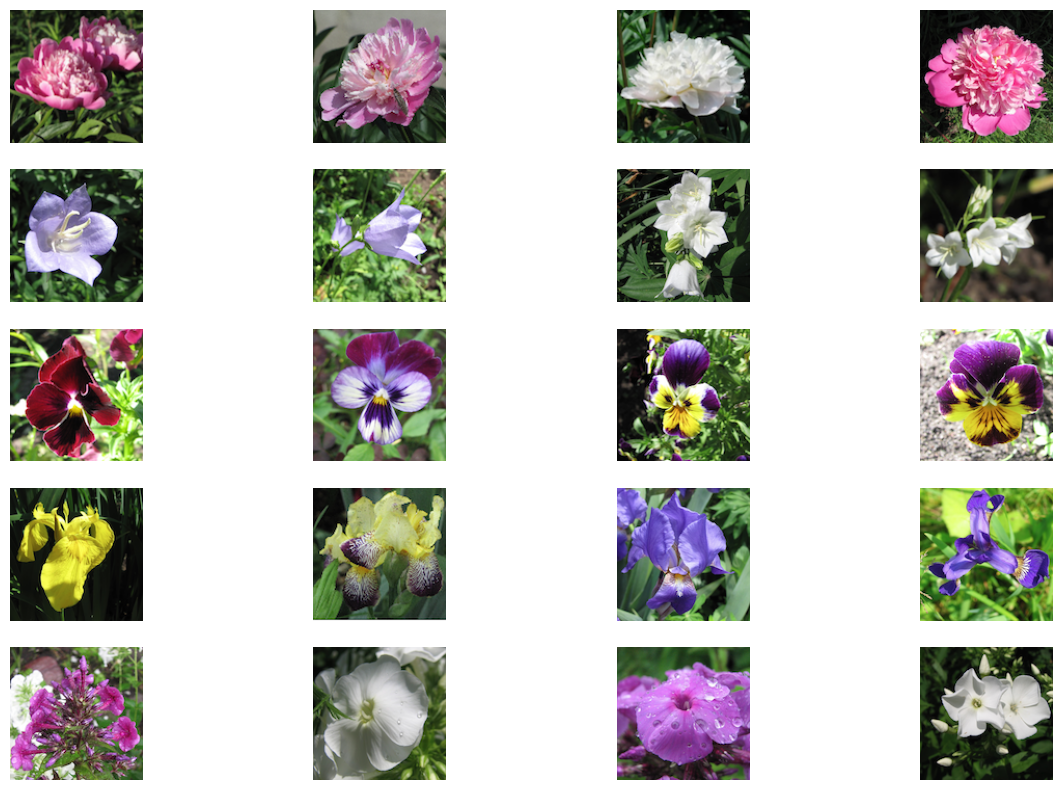

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load the dataset as DataFrame
flowersList_df = pd.DataFrame(data=flowersList, columns=['category', 'image'])

# Check the number of samples for each category
print("Total number of flowers in the dataset: ", len(flowersList_df))
flowerNum = flowersList_df['category'].value_counts()
print("Flowers in each category: ")
print(flowerNum)

# A list for storing names of some random samples from each category
RanSamples = []

# Get samples from each category
for category in flowerNum.index:
    samples = flowersList_df['image'][flowersList_df['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

# Limit the number of samples to match the number of subplots
RanSamples = RanSamples[:20]

# Plot the samples
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

for i, sample in enumerate(RanSamples):
    img = Image.open(sample)  # Use PIL to open the image
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].axis('off')

plt.show()


This snippet is to visualise how many samples we've for each flower type in the bar chart.

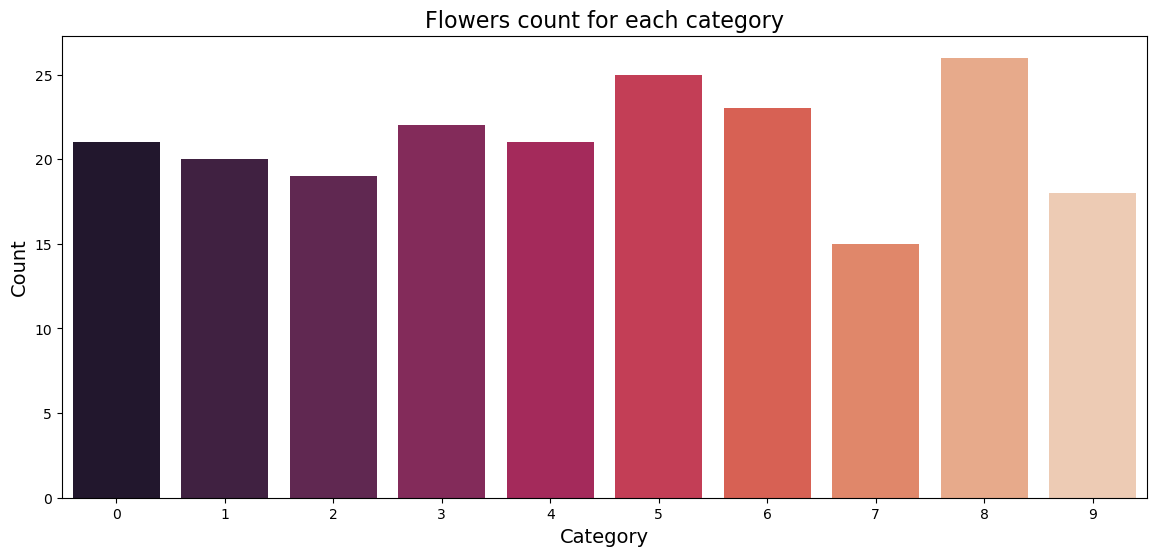

In [10]:
# Let's do some visualization and see how many samples we have for each category
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

In [13]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Directory paths
trainDir = './test/trainDir'
valDir = './test/valDir'

# Categories are numerically labeled from 0 to 9
categories = list(range(10))

# Create directories
def create_directory(dirName, categories):
    if os.path.exists(dirName):
        shutil.rmtree(dirName)
    os.makedirs(dirName)
    for category in categories:
        os.makedirs(os.path.join(dirName, str(category)))

create_directory(trainDir, categories)
create_directory(valDir, categories)

# Prepare lists for images and labels
trainImg, trainLabel = [], []
validImg, validLabel = [], []

# Distribute images between training and validation directories
for category in categories:
    samples = flowersList_df['image'][flowersList_df['category'] == category].values
    np.random.shuffle(samples)
    
    # Calculate the split index (half of the images go to validation set)
    split_index = len(samples) // 2
    
    # Validation set
    for sample in samples[:split_index]:
        name = os.path.basename(sample)
        shutil.copyfile(sample, os.path.join(valDir, str(category), name))
        
        try:
            img = plt.imread(os.path.join(valDir, str(category), name))
            img = cv2.resize(img, (150, 150))
            validImg.append(np.array(img))
            validLabel.append(category)
        except Exception as e:
            pass
        
    # Training set
    for sample in samples[split_index:]:
        name = os.path.basename(sample)
        shutil.copyfile(sample, os.path.join(trainDir, str(category), name))

        try:
            img = plt.imread(os.path.join(trainDir, str(category), name))
            img = cv2.resize(img, (150, 150))
            trainImg.append(np.array(img))
            trainLabel.append(category)
        except Exception as e:
            pass

# Convert labels to categorical
validLabel = to_categorical(validLabel, num_classes=len(categories))
trainLabel = to_categorical(trainLabel, num_classes=len(categories))

# Normalize image data
validImg = np.array(validImg) / 255.0
trainImg = np.array(trainImg) / 255.0

# Output the shapes of arrays
print("\nLengths of the corresponding array dimensions: \n")
print(np.shape(validImg), np.shape(validLabel), np.shape(trainImg), np.shape(trainLabel))



Lengths of the corresponding array dimensions: 

(102, 150, 150, 4) (102, 10) (108, 150, 150, 4) (108, 10)


#### Creating the model
We are using Conv2D and MaxPooling2D layers as the convolutional base:
   - Conv2D: The first required Conv2D parameter is the number of filters that the convolutional layer will learn.    
   - MaxPooling2D: used to reduce the spatial dimensions of the output volume.
We used ReLU as our activation function:
 

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def createModel():
    model = Sequential()
    
    # Learn a total of 32 filters, kernel size 3x3
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Learn a total of 64 filters, kernel size 3x3
    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Learn a total of 96 filters, kernel size 3x3
    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Learn a total of 128 filters, kernel size 3x3
    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add Dense layers on top
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    
    # Output layer for 10 categories
    model.add(Dense(10, activation='softmax'))

    return model


In [40]:
# Compile the model
model = createModel()
batch_size = 100
epochs = 50

model.compile(
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    optimizer='RMSprop',              # RMSprop optimizer is a good choice for CNNs
    metrics=['accuracy']              # Tracking accuracy during training
)

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 18, 18, 128)         │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,842,538 (10.84 MB)

 Trainable params: 2,842,538 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting on the Training set & making predcitons on the Validation set

In [41]:
# Create data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # Don't normalize the entire dataset to have a mean of 0
        samplewise_center=False,  # Don't normalize each sample to have a mean of 0
        featurewise_std_normalization=False,  # Don't divide inputs by the dataset std
        samplewise_std_normalization=False,  # Don't divide each input by its std
        zca_whitening=False,  # Don't apply ZCA whitening
        rotation_range=90,  # Randomly rotate images by up to 90 degrees
        zoom_range=0.1,  # Randomly zoom in on images by up to 10%
        width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
        height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the height
        shear_range=0.1,  # Apply shear transformations
        horizontal_flip=True,  # Randomly flip images horizontally
        vertical_flip=False  # Don't flip images vertically (uncommon for most real-world scenarios)
)

# Fit the generator on the training data
datagen.fit(trainImg)

# Start training
'''
verbose: 0 shows nothing; 1 will show an animated progress bar; 2 will show the number of epochs.
batch_size: Number of samples that will be propagated through the network in one batch.
epochs: Number of complete passes through the training dataset.
'''
History = model.fit(
    trainImg, 
    trainLabel, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(validImg, validLabel), 
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.0760 - loss: 2.3027 - val_accuracy: 0.1078 - val_loss: 2.3009
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.1107 - loss: 2.3014 - val_accuracy: 0.1078 - val_loss: 2.2996
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.1074 - loss: 2.3009 - val_accuracy: 0.1078 - val_loss: 2.2997
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.1107 - loss: 2.3009 - val_accuracy: 0.1078 - val_loss: 2.2984
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.1074 - loss: 2.2990 - val_accuracy: 0.1078 - val_loss: 2.2987
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 0.1141 - loss: 2.2988 - val_accuracy: 0.1078 - val_loss: 2.2983
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.1107 - loss: 2.2986 - val_accuracy: 0.1078 - val_loss: 2.2992
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.1107 - loss: 2.2998 - val_accuracy: 0.1078 - val_loss:

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(trainImg)

# Compile the model
model = createModel()
batch_size = 100
epochs = 50

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',  # Try Adam optimizer
    metrics=['accuracy']
)

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(trainImg, trainLabel, batch_size=batch_size), 
    epochs=epochs, 
    validation_data=(validImg, validLabel),
    callbacks=[lr_reduction, early_stopping],
    verbose=1
)

model.summary()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.1046 - loss: 2.3028 - val_accuracy: 0.1275 - val_loss: 2.3012 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1219 - loss: 2.3011 - val_accuracy: 0.1275 - val_loss: 2.2983 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1219 - loss: 2.3057 - val_accuracy: 0.1275 - val_loss: 2.2965 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.1136 - loss: 2.2983 - val_accuracy: 0.1275 - val_loss: 2.2937 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.1236 - loss: 2.2955 - val_accuracy: 0.1275 - val_loss: 2.2932 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1169 - loss: 2.2977 - val_accuracy: 0.1275 - val_loss: 2.2930 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.1169 - loss: 2.2974 - val_accuracy: 0.1275

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 18, 18, 128)         │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,527,616 (32.53 MB)

 Trainable params: 2,842,538 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,685,078 (21.69 MB)

 #### Visualizing Predictons on the Validation Set

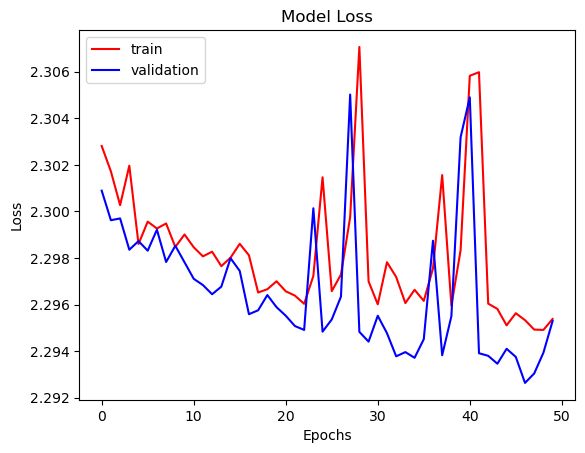

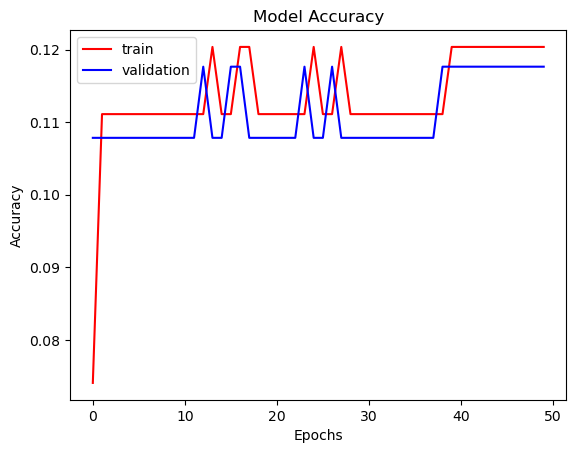

In [43]:
# Loss
plt.plot(History.history['loss'], "r")
plt.plot(History.history['val_loss'], "b")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

# Accuracy
plt.plot(History.history['accuracy'], "r")
plt.plot(History.history['val_accuracy'],"b")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model


In [71]:
model = create_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


In [72]:
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(trainImg)


In [73]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    datagen.flow(trainImg, trainLabel, batch_size=100),
    epochs=50,
    validation_data=(validImg, validLabel),
    callbacks=[lr_reduction, early_stopping],
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0972 - loss: 2.3032 - val_accuracy: 0.1275 - val_loss: 2.3000 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1991 - loss: 2.2983 - val_accuracy: 0.1176 - val_loss: 2.2973 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.1264 - loss: 2.2932 - val_accuracy: 0.1176 - val_loss: 2.3071 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1157 - loss: 2.3237 - val_accuracy: 0.1176 - val_loss: 2.3176 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.0509 - loss: 2.2975    
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0679 - loss: 2.3008 - val_accuracy: 0.0980 - val_loss: 2.3039 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.1012 - loss: 2.3143 - val_accuracy: 0.0980 -

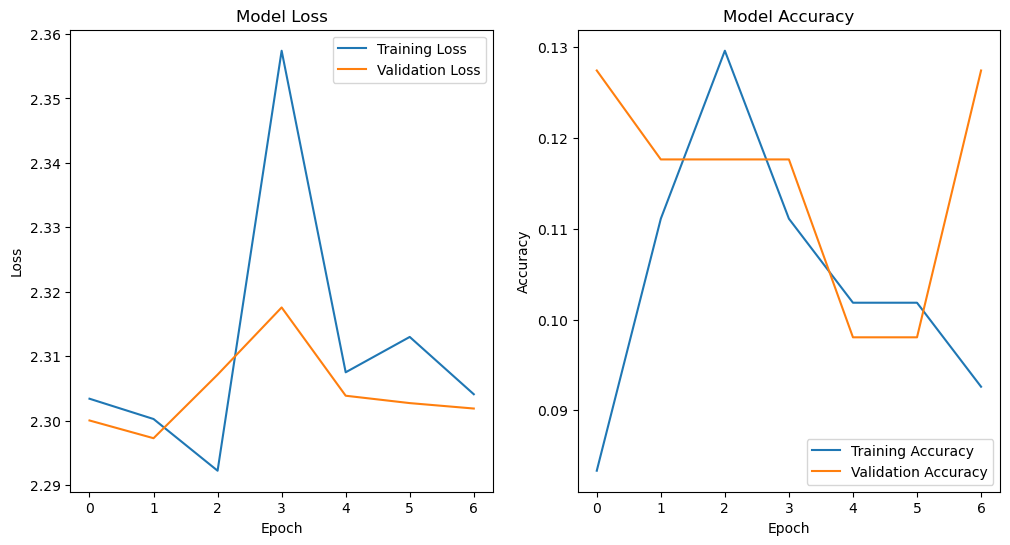

In [88]:
# Save plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')

plt.show()


# STEPS
Set Parameters:

img_width and img_height define the target size for resizing images to 64x64 pixels.
batch_size is set to 32, which determines the number of images processed before the model's weights are updated.
epochs is set to 50, indicating the number of times the entire dataset will pass through the model during training.
latent_dim is set to 128, which defines the dimension of the latent feature space in the autoencoder.
Load and Preprocess Images:

The load_and_preprocess_images() function loads the images from the specified data_path.
Images are resized to 64x64 pixels, converted to arrays, normalized (pixel values between 0 and 1), and then stored in a list.
The function returns the processed images and their filenames.
Build the Autoencoder Model:

An autoencoder is a type of neural network used to learn efficient representations of data, typically for dimensionality reduction.
The input shape is defined as (64, 64, 3) for color images.
Encoder: The encoder compresses the input images into a lower-dimensional representation using a series of convolutional layers (Conv2D) and max pooling layers (MaxPooling2D).
Decoder: The decoder reconstructs the original image from the lower-dimensional representation using convolutional layers and upsampling layers (UpSampling2D).
Compile and Summarize the Autoencoder Model:

The autoencoder model is compiled using the adam optimizer and mean_squared_error loss function, which is suitable for image reconstruction tasks.
The model summary is printed to display the architecture and number of parameters at each layer.
Train the Autoencoder:

The autoencoder is trained using the processed images as both the input and the target (since it's an autoencoder). The fit() method is used to train the model for 50 epochs with a batch size of 32.
Extract Features Using the Encoder:

After training the autoencoder, the encoder part of the model is used to extract features from the images. This step helps in reducing the dimensionality of the images while retaining important features.
The predict() method of the encoder model is used to generate the encoded (compressed) representations of the images.
Flatten Features for Clustering:

The extracted features are flattened into a 2D array using reshape() so that they can be fed into the K-Means clustering algorithm. Each row represents an image, and each column represents a feature.
Apply K-Means Clustering:

K-Means clustering is applied to the flattened feature vectors to group the images into n_clusters (in this case, 5 clusters).
The fit_predict() method assigns each image to a cluster based on its feature vector.
Display Clustering Results:

The code iterates through each cluster, identifies the indices of images belonging to that cluster, and displays the first 10 images in each cluster using matplotlib.
The images are displayed in a grid for each cluster to visually inspect the clustering results.

Model: "functional_283"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_91 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_92 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_93 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0933
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0746
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0533
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0446
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0388
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0349
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0329
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0315
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0309
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0289
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0275
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0274
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0254
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0245
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0236
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster 1:


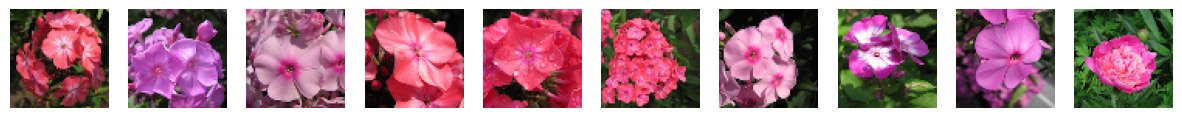


Cluster 2:


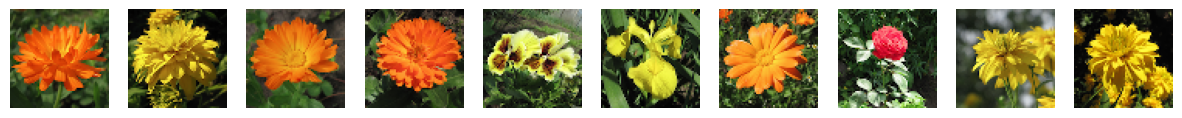


Cluster 3:


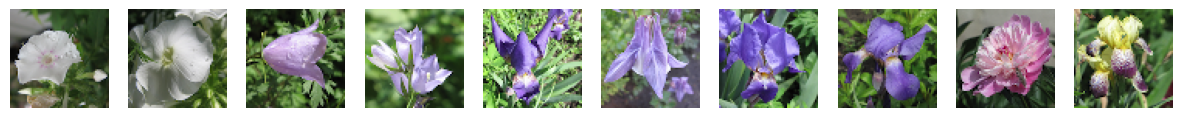


Cluster 4:


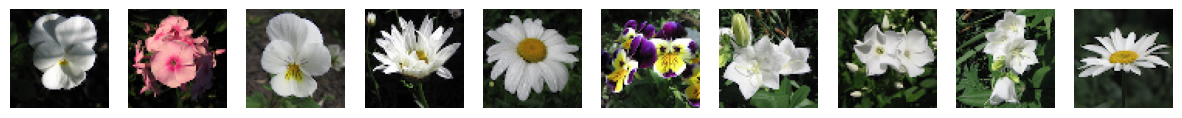


Cluster 5:


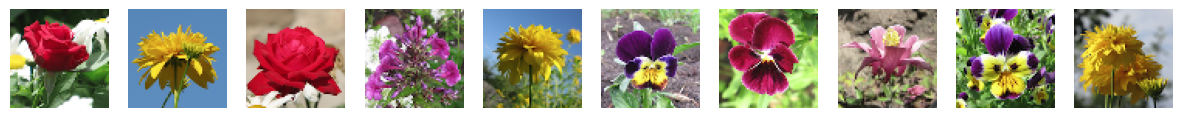

In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define the path to your dataset
data_path = r"C:\Users\User\Downloads\4-mds\4-mds"

# Parameters
img_width, img_height = 64, 64  # Adjust based on your GPU memory and dataset size
batch_size = 32
epochs = 50
latent_dim = 128  # Dimension of latent space (feature space)

# Load images and preprocess
def load_and_preprocess_images(data_path):
    images = []
    image_files = [f for f in os.listdir(data_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    for image_file in image_files:
        image_path = os.path.join(data_path, image_file)
        img = load_img(image_path, target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    
    images = np.array(images)
    return images, image_files

images, image_files = load_and_preprocess_images(data_path)

# Build an Autoencoder Model
input_img = Input(shape=(img_width, img_height, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Train the Autoencoder
history = autoencoder.fit(
    images, images,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)

# Feature Extraction Model (Encoder)
encoder = Model(input_img, encoded)
features = encoder.predict(images)

# Flatten and reshape features for clustering
features_flattened = features.reshape(features.shape[0], -1)  # Flatten

# Apply K-Means Clustering
n_clusters = 5  # Define number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_flattened)

# Display Clustering Results
for cluster_num in range(n_clusters):
    cluster_indices = np.where(clusters == cluster_num)[0]
    print(f"\nCluster {cluster_num + 1}:")
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(cluster_indices[:10]):  # Display first 10 images in each cluster
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.show()


The provided code performs image clustering using an autoencoder and K-Means algorithm. It starts by defining the path to a dataset of images and setting parameters like image size, batch size, and epochs. The load_and_preprocess_images function reads images from the specified directory, resizes them, normalizes their pixel values, and converts them into a NumPy array.

An autoencoder model is then built and trained. The autoencoder consists of an encoder that compresses the images into a lower-dimensional latent space and a decoder that reconstructs the images from this latent representation. After training, the encoder part of the autoencoder is used to extract features from the images. These features are then flattened to prepare them for clustering.

K-Means clustering is applied to these flattened features to group the images into a specified number of clusters (in this case, 5 clusters). Finally, the results of the clustering are visualized by displaying the first 10 images from each cluster, providing an insight into the groupings made by the K-Means algorithm.










Cluster 1: (36 images)


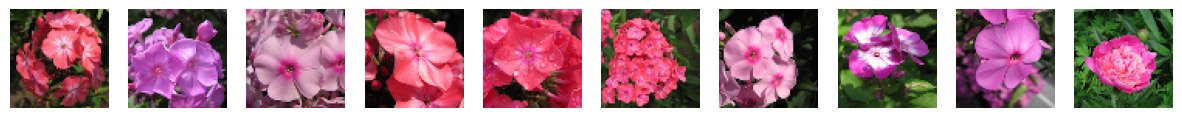


Cluster 2: (47 images)


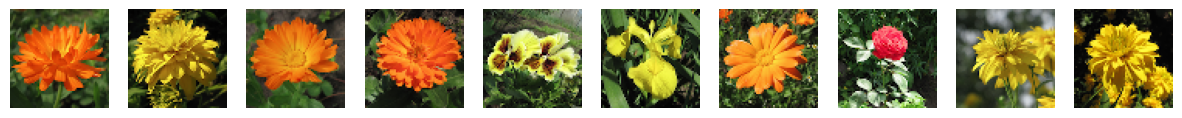


Cluster 3: (46 images)


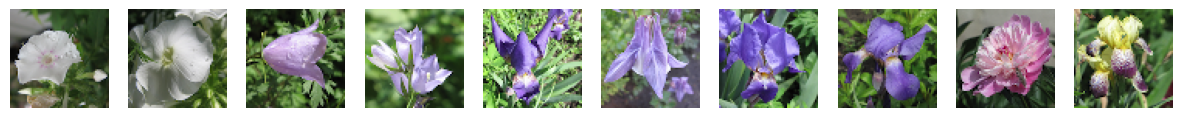


Cluster 4: (47 images)


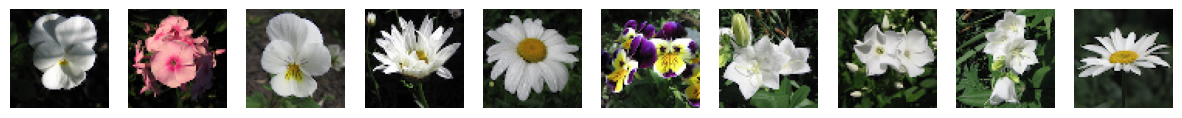


Cluster 5: (34 images)


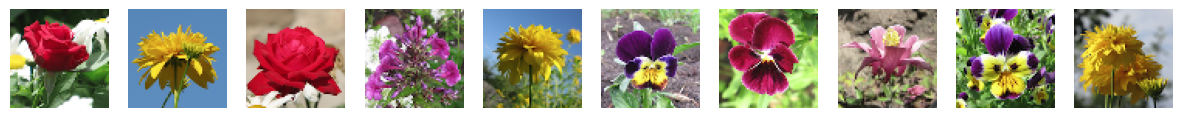

In [106]:
# Display Clustering Results: Images by Cluster
def visualize_images_by_cluster(images, clusters, n_clusters, max_images=10):
    for cluster_num in range(n_clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        print(f"\nCluster {cluster_num + 1}: ({len(cluster_indices)} images)")
        
        # Display first `max_images` images in each cluster
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(cluster_indices[:max_images]):
            plt.subplot(1, max_images, i + 1)
            plt.imshow(images[idx])
            plt.axis('off')
        plt.show()

# Visualize Images by Cluster
visualize_images_by_cluster(images, clusters, n_clusters=5)


C:\Users\User\AppData\Local\Temp\ipykernel_139224\1828626162.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)  # Color map


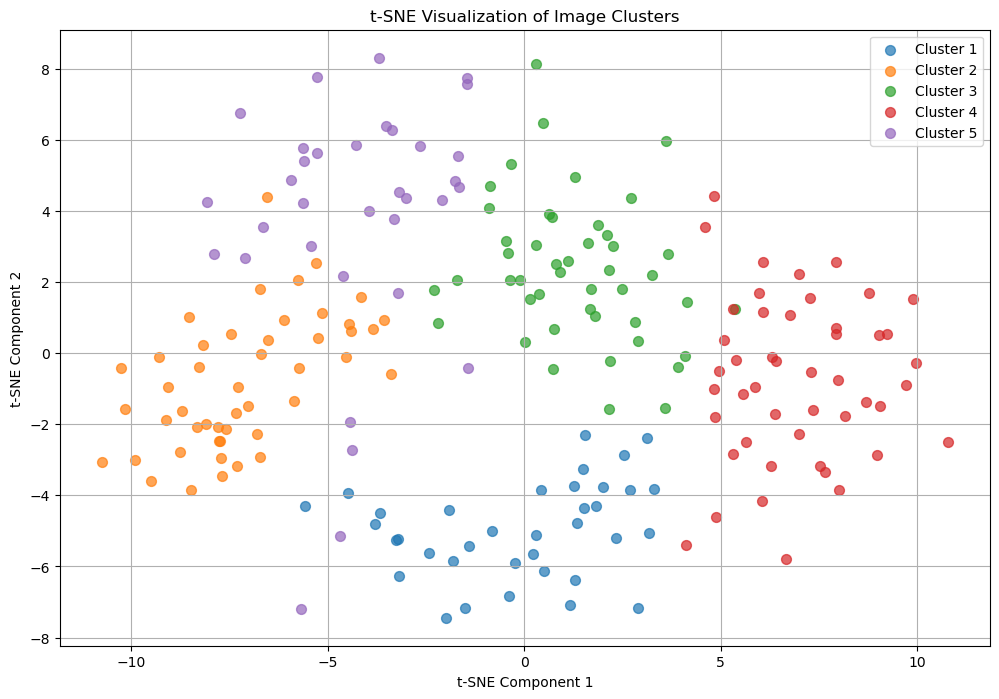

In [107]:
from sklearn.manifold import TSNE

# Reduce dimensions with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_flattened)

# Plot t-SNE Results
def plot_tsne(features, clusters, n_clusters):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.get_cmap('tab10', n_clusters)  # Color map

    for cluster_num in range(n_clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        cluster_features = features[cluster_indices]
        plt.scatter(cluster_features[:, 0], cluster_features[:, 1], label=f'Cluster {cluster_num + 1}', alpha=0.7, s=50)

    plt.title('t-SNE Visualization of Image Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize Clusters with t-SNE
plot_tsne(features_tsne, clusters, n_clusters=5)


Model: "functional_286"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_97 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_98 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_99 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 0.0890 - val_loss: 0.0742
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0706 - val_loss: 0.0564
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0619 - val_loss: 0.0575
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0540 - val_loss: 0.0477
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0464 - val_loss: 0.0461
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0414 - val_loss: 0.0426
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0383 - val_loss: 0.0375
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0353 - val_loss: 0.0361
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0328 - val_loss: 0.0345
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0316 - val_loss: 0.0333
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0305 - val_loss: 0.0317
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0300 - val_loss: 0.0307

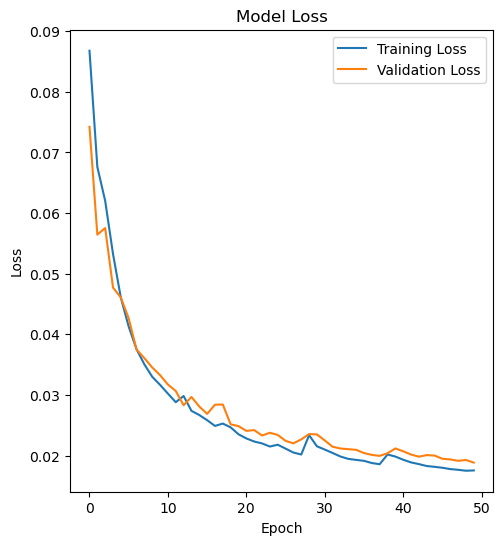

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster 1:


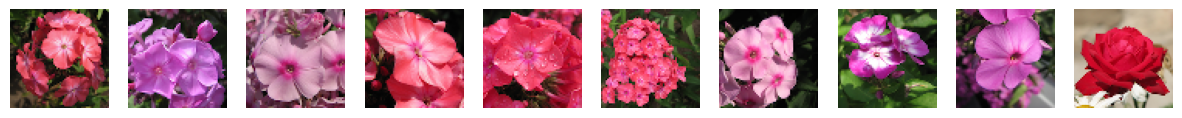


Cluster 2:


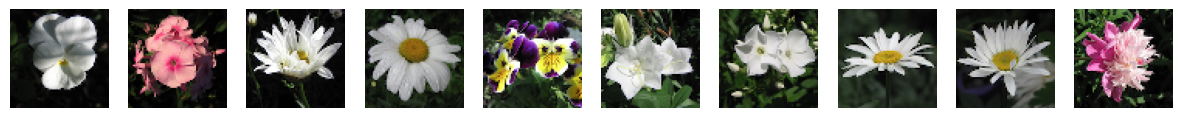


Cluster 3:


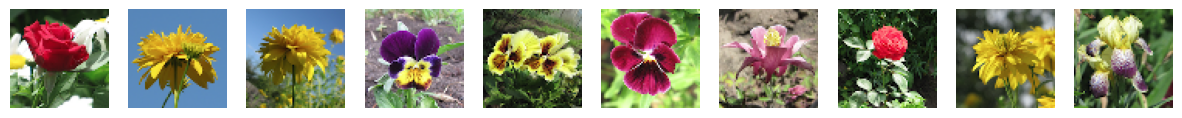


Cluster 4:


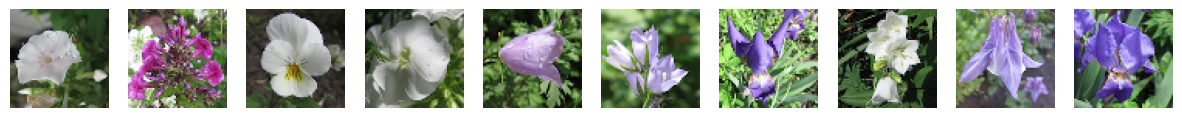


Cluster 5:


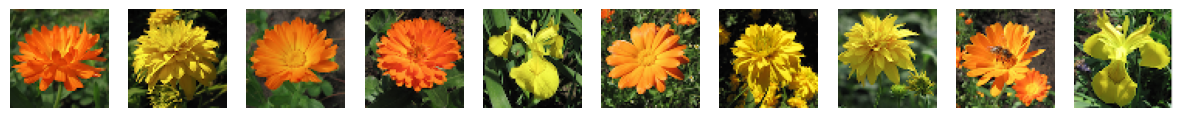

In [111]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define the path to your dataset
data_path = r"C:\Users\User\Downloads\4-mds\4-mds"

# Parameters
img_width, img_height = 64, 64
batch_size = 32
epochs = 50
latent_dim = 128

# Load images and preprocess
def load_and_preprocess_images(data_path):
    images = []
    image_files = [f for f in os.listdir(data_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    for image_file in image_files:
        image_path = os.path.join(data_path, image_file)
        img = load_img(image_path, target_size=(img_width, img_height))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    
    images = np.array(images)
    return images, image_files

images, image_files = load_and_preprocess_images(data_path)

# Build an Autoencoder Model
input_img = Input(shape=(img_width, img_height, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Train the Autoencoder
history = autoencoder.fit(
    images, images,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2  # Adding validation data
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Optionally, plot more metrics if available
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

plt.show()

# Feature Extraction Model (Encoder)
encoder = Model(input_img, encoded)
features = encoder.predict(images)

# Flatten and reshape features for clustering
features_flattened = features.reshape(features.shape[0], -1)

# Apply K-Means Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_flattened)

# Display Clustering Results
for cluster_num in range(n_clusters):
    cluster_indices = np.where(clusters == cluster_num)[0]
    print(f"\nCluster {cluster_num + 1}:")
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(cluster_indices[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.show()


Interpreation of some clusters

Cluster 2:

This cluster appears to contain flowers that have lighter colors, such as white, pink, and light shades. There are several daisy-like flowers (white petals with a yellow center) and other flowers with white or pale pink petals.
The clustering algorithm has grouped together images that have similar color schemes (white and light colors) and somewhat similar petal structures.

Cluster 3:

This cluster seems to include flowers with more vibrant and varied colors, including red, yellow, and purple. The flowers have different shapes and colors, such as red roses, yellow daisy-like flowers, and pansies (purple and yellow).
Here, the clustering algorithm has grouped together flowers that have more vibrant and contrasting colors. The cluster includes a variety of flower types, which indicates that the primary feature used for clustering in this group might be color intensity and diversity.